In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

plt.rcParams.update({'font.size': 35})

<h1>Things to compare</h1>
<div>
<ul>
  <li>l1 Comparing Measures of Sparsity</li>
  <li>l2 Comparing Measures of Sparsity</li>
  <li>l1 MEASURING SPARSENESS OF NOISY SIGNAL</li>
  <li>l2 MEASURING SPARSENESS OF NOISY SIGNAL</li>
  <li>Depending on the result choose the good one for l2/l1</li>
  <li>tanh</li>
  <li>log</li>
</ul>
</div>

In [2]:
# read all of the data
# https://github.com/mttk/STL10
plt.rcParams.update({'font.size': 35})
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [12]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.regularizer    = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.regularizer == 1: grad = grad - lamda * tf.ones_like(self.w)
        if self.regularizer == 2: grad = grad - lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.regularizer == 3: grad = grad + lamda * tf.sign(self.w)
        if self.regularizer == 4: grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
def save_to_image(data,name):
    l1g,l2g,l3g,l4g,l5g,l6g = data
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig(name + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')     

In [23]:
# set hyper parameter
plt.rcParams.update({'font.size': 35})
num_epoch = 150; learning_rate = 0.0008; batch_size = 20; beta1,beta2,adam_e = 0.9,0.999,1e-9; lamda = 0.00001

In [22]:
# 1. no reg
current_exp_name = 'none/'; current_regularizer = 0
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.125600002348423 Test Acc : 0.2070000032056123

Current Iter : 1/150 batch : 7980/8000 acc : 0.45
 Current : 1 Train Acc : 0.1954000028371811 Test Acc : 0.2666250026598573

Current Iter : 2/150 batch : 7980/8000 acc : 0.35
 Current : 2 Train Acc : 0.27020000225305557 Test Acc : 0.30850000243633985

Current Iter : 3/150 batch : 7980/8000 acc : 0.45
 Current : 3 Train Acc : 0.3038000022023916 Test Acc : 0.33375000196509064

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Train Acc : 0.3174000024348497 Test Acc : 0.3382500016316772

Current Iter : 5/150 batch : 7980/8000 acc : 0.45
 Current : 5 Train Acc : 0.32720000243186953 Test Acc : 0.3420000012218952

Current Iter : 6/150 batch : 7980/8000 acc : 0.55
 Current : 6 Train Acc : 0.3340000012665987 Test Acc : 0.34787500174716113

Current Iter : 7/150 batch : 7980/8000 acc : 0.55
 Current : 7 Train Acc : 0.33800000095367433 Test Acc : 0.3521250021457

Current Iter : 64/150 batch : 7980/8000 acc : 0.45
 Current : 64 Train Acc : 0.5094000031352043 Test Acc : 0.4561250011436641

Current Iter : 65/150 batch : 7980/8000 acc : 0.45
 Current : 65 Train Acc : 0.5096000025868416 Test Acc : 0.45587500097230077

Current Iter : 66/150 batch : 7980/8000 acc : 0.45
 Current : 66 Train Acc : 0.5114000026583672 Test Acc : 0.45725000159814955

Current Iter : 67/150 batch : 7980/8000 acc : 0.45
 Current : 67 Train Acc : 0.5172000022530556 Test Acc : 0.45737500136718157

Current Iter : 68/150 batch : 7980/8000 acc : 0.45
 Current : 68 Train Acc : 0.517600002348423 Test Acc : 0.4590000013820827

Current Iter : 69/150 batch : 7980/8000 acc : 0.45
 Current : 69 Train Acc : 0.5190000022053719 Test Acc : 0.45875000083819034

Current Iter : 70/150 batch : 7980/8000 acc : 0.45
 Current : 70 Train Acc : 0.521200001180172 Test Acc : 0.46162500144913793

Current Iter : 71/150 batch : 7980/8000 acc : 0.45
 Current : 71 Train Acc : 0.5234000014066696 Test Acc : 0

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.602800001502037 Test Acc : 0.520375001616776

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.602000000834465 Test Acc : 0.522875001206994

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.6062000007629395 Test Acc : 0.5232500013709068

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.6054000005722046 Test Acc : 0.5232500015944243

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.6062000008821488 Test Acc : 0.5231250014156104

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.6062000012397766 Test Acc : 0.5240000013634563

Current Iter : 134/150 batch : 7980/8000 acc : 0.55
 Current : 134 Train Acc : 0.6096000010967255 Test Acc : 0.5231250016391278

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.609400000333786 Test

In [24]:
# 2. l1 from c
current_exp_name = 'l1_a/'; current_regularizer = 1
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.10420000216364861 Test Acc : 0.10137500228360295

Current Iter : 1/150 batch : 7980/8000 acc : 0.15
 Current : 1 Train Acc : 0.12380000272393227 Test Acc : 0.1476250028144568

Current Iter : 2/150 batch : 7980/8000 acc : 0.25
 Current : 2 Train Acc : 0.15800000275671483 Test Acc : 0.20675000318326056

Current Iter : 3/150 batch : 7980/8000 acc : 0.15
 Current : 3 Train Acc : 0.20840000315010548 Test Acc : 0.2392500031646341

Current Iter : 4/150 batch : 7980/8000 acc : 0.35
 Current : 4 Train Acc : 0.25160000298917296 Test Acc : 0.2590000025369227

Current Iter : 5/150 batch : 7980/8000 acc : 0.35
 Current : 5 Train Acc : 0.2906000027358532 Test Acc : 0.312750002341345

Current Iter : 6/150 batch : 7980/8000 acc : 0.45
 Current : 6 Train Acc : 0.31620000217854977 Test Acc : 0.3327500021271408

Current Iter : 7/150 batch : 7980/8000 acc : 0.35
 Current : 7 Train Acc : 0.3360000019818544 Test Acc : 0.35350000096

Current Iter : 64/150 batch : 7980/8000 acc : 0.55
 Current : 64 Train Acc : 0.47480000007152556 Test Acc : 0.4541250009462237

Current Iter : 65/150 batch : 7980/8000 acc : 0.55
 Current : 65 Train Acc : 0.4731999990940094 Test Acc : 0.45412500098347663

Current Iter : 66/150 batch : 7980/8000 acc : 0.55
 Current : 66 Train Acc : 0.4751999982595444 Test Acc : 0.4543750010803342

Current Iter : 67/150 batch : 7980/8000 acc : 0.55
 Current : 67 Train Acc : 0.47599999982118607 Test Acc : 0.4537500010058284

Current Iter : 68/150 batch : 7980/8000 acc : 0.55
 Current : 68 Train Acc : 0.4794000005722046 Test Acc : 0.4548750013113022

Current Iter : 69/150 batch : 7980/8000 acc : 0.55
 Current : 69 Train Acc : 0.479800000667572 Test Acc : 0.4550000012293458

Current Iter : 70/150 batch : 7980/8000 acc : 0.45
 Current : 70 Train Acc : 0.48060000026226046 Test Acc : 0.45250000070780516

Current Iter : 71/150 batch : 7980/8000 acc : 0.45
 Current : 71 Train Acc : 0.4830000008940697 Test Acc : 

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.5460000012516976 Test Acc : 0.4933750020340085

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.5488000010251999 Test Acc : 0.493000001385808

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.5474000019431114 Test Acc : 0.4933750019967556

Current Iter : 131/150 batch : 7980/8000 acc : 0.55
 Current : 131 Train Acc : 0.5490000016093254 Test Acc : 0.494875001385808

Current Iter : 132/150 batch : 7980/8000 acc : 0.55
 Current : 132 Train Acc : 0.549000001847744 Test Acc : 0.4957500014826655

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.5494000021219253 Test Acc : 0.49537500146776436

Current Iter : 134/150 batch : 7980/8000 acc : 0.55
 Current : 134 Train Acc : 0.5514000008106231 Test Acc : 0.4977500012889504

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Train Acc : 0.5490000011920929 T

In [25]:
# 3. l2 from c
current_exp_name = 'l2_a/'; current_regularizer = 2
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Train Acc : 0.12860000263154506 Test Acc : 0.1533750030491501

Current Iter : 1/150 batch : 7980/8000 acc : 0.15
 Current : 1 Train Acc : 0.21320000292360783 Test Acc : 0.27387500297278167

Current Iter : 2/150 batch : 7980/8000 acc : 0.45
 Current : 2 Train Acc : 0.26320000256598 Test Acc : 0.2916250025201589

Current Iter : 3/150 batch : 7980/8000 acc : 0.45
 Current : 3 Train Acc : 0.2966000021100044 Test Acc : 0.3205000018049031

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Train Acc : 0.3234000019282103 Test Acc : 0.3393750017788261

Current Iter : 5/150 batch : 7980/8000 acc : 0.45
 Current : 5 Train Acc : 0.3406000017076731 Test Acc : 0.3493750014528632

Current Iter : 6/150 batch : 7980/8000 acc : 0.45
 Current : 6 Train Acc : 0.3594000019729137 Test Acc : 0.3537500009778887

Current Iter : 7/150 batch : 7980/8000 acc : 0.45
 Current : 7 Train Acc : 0.36580000130832196 Test Acc : 0.3601250004582107

Current Iter : 64/150 batch : 7980/8000 acc : 0.45
 Current : 64 Train Acc : 0.5510000022053718 Test Acc : 0.46762500116601585

Current Iter : 65/150 batch : 7980/8000 acc : 0.45
 Current : 65 Train Acc : 0.5516000021100044 Test Acc : 0.47025000099092723

Current Iter : 66/150 batch : 7980/8000 acc : 0.55
 Current : 66 Train Acc : 0.5546000028252601 Test Acc : 0.47437500115484

Current Iter : 67/150 batch : 7980/8000 acc : 0.55
 Current : 67 Train Acc : 0.55540000218153 Test Acc : 0.4746250008419156

Current Iter : 68/150 batch : 7980/8000 acc : 0.55
 Current : 68 Train Acc : 0.5602000021338462 Test Acc : 0.4751250008866191

Current Iter : 69/150 batch : 7980/8000 acc : 0.55
 Current : 69 Train Acc : 0.560000002026558 Test Acc : 0.47900000132620335

Current Iter : 70/150 batch : 7980/8000 acc : 0.55
 Current : 70 Train Acc : 0.5630000032186508 Test Acc : 0.4782500012218952

Current Iter : 71/150 batch : 7980/8000 acc : 0.55
 Current : 71 Train Acc : 0.5634000016450882 Test Acc : 0.4810

Current Iter : 128/150 batch : 7980/8000 acc : 0.55
 Current : 128 Train Acc : 0.6505999989509582 Test Acc : 0.502750001475215

Current Iter : 129/150 batch : 7980/8000 acc : 0.55
 Current : 129 Train Acc : 0.6535999994277955 Test Acc : 0.5036250018328429

Current Iter : 130/150 batch : 7980/8000 acc : 0.55
 Current : 130 Train Acc : 0.6532000000476837 Test Acc : 0.5035000019147993

Current Iter : 131/150 batch : 7980/8000 acc : 0.65
 Current : 131 Train Acc : 0.654400000333786 Test Acc : 0.504125002026558

Current Iter : 132/150 batch : 7980/8000 acc : 0.65
 Current : 132 Train Acc : 0.6564000004529953 Test Acc : 0.5032500018924475

Current Iter : 133/150 batch : 7980/8000 acc : 0.55
 Current : 133 Train Acc : 0.6572000002861023 Test Acc : 0.5031250020116568

Current Iter : 134/150 batch : 7980/8000 acc : 0.65
 Current : 134 Train Acc : 0.6590000007152558 Test Acc : 0.502250001579523

Current Iter : 135/150 batch : 7980/8000 acc : 0.65
 Current : 135 Train Acc : 0.6612000004053116 Tes

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


FileNotFoundError: [Errno 2] No such file or directory: 'l1_b/gradient_update/0.png'

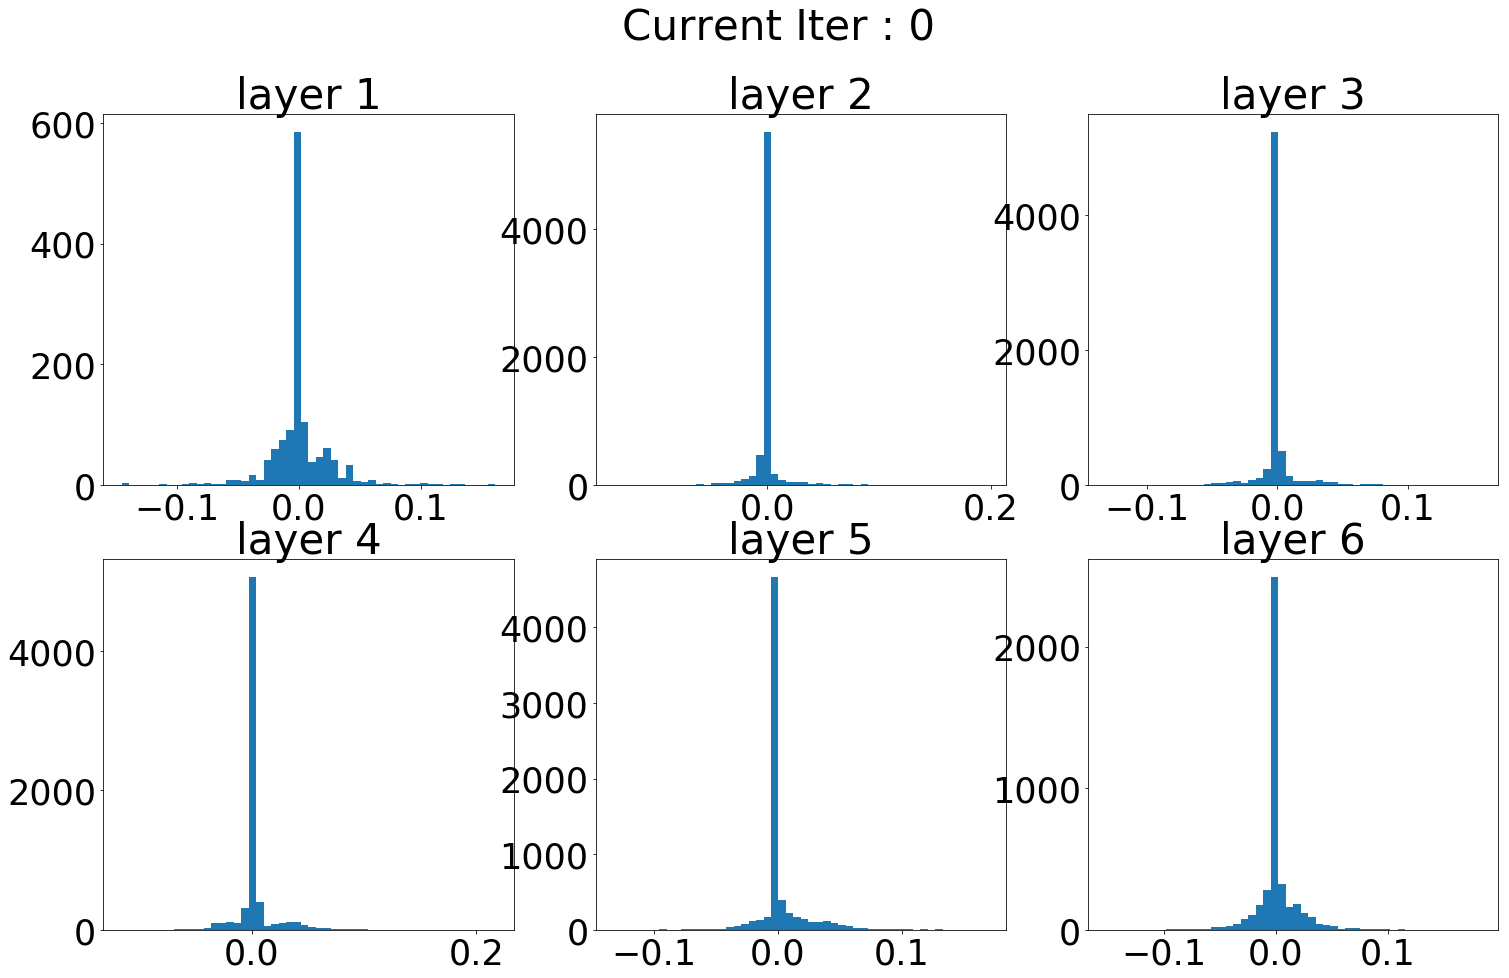

In [26]:
# 4. l1 from M
current_exp_name = 'l1_b/'; current_regularizer = 3
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16,which_reg=current_regularizer); 
l2 = CNN(3,16,16,which_reg=current_regularizer); 
l3 = CNN(3,16,16,which_reg=current_regularizer); 

l4 = CNN(3,16,16,which_reg=current_regularizer); 
l5 = CNN(3,16,16,which_reg=current_regularizer); 
l6 = CNN(3,16,10,which_reg=current_regularizer); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer5, layer5a = l5. feedforward(layer4a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)
grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([layer1,layer2,layer3,layer4,layer5,layer6],feed_dict={x:current_data,y:current_label}),current_exp_name+'layer/')
    save_to_image(sess.run([layer1a,layer2a,layer3a,layer4a,layer5a,layer6a],feed_dict={x:current_data,y:current_label}),current_exp_name+'layera/')
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),current_exp_name+'weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),current_exp_name+'gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Train Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save(current_exp_name+'train.npy',train_acc)
np.save(current_exp_name+'test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

In [6]:
# 2. batch normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_batch_norm_layer(16,(0,1,2))
l2 = CNN(3,16,16); l2n = tf_batch_norm_layer(16,(0,1,2))
l3 = CNN(3,16,16); l3n = tf_batch_norm_layer(16,(0,1,2))
l4 = CNN(3,16,16); l4n = tf_batch_norm_layer(16,(0,1,2))
l5 = CNN(3,16,16); l5n = tf_batch_norm_layer(16,(0,1,2))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'batch Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'batch Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'batch Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('batch Norm/train.npy',train_acc)
np.save('batch Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

Current Iter : 0/150 batch : 7980/8000 acc : 0.35
 Current : 0 Acc : 0.2912000026255846 Test Acc : 0.34337500234134494

Current Iter : 1/150 batch : 7980/8000 acc : 0.35
 Current : 1 Acc : 0.36260000175237656 Test Acc : 0.3870000005699694

Current Iter : 2/150 batch : 7980/8000 acc : 0.35
 Current : 2 Acc : 0.39380000191926956 Test Acc : 0.4041250008158386

Current Iter : 3/150 batch : 7980/8000 acc : 0.45
 Current : 3 Acc : 0.42120000106096267 Test Acc : 0.4147500023432076

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Acc : 0.4457999997735024 Test Acc : 0.4216250019706786

Current Iter : 5/150 batch : 7980/8000 acc : 0.45
 Current : 5 Acc : 0.46980000096559527 Test Acc : 0.41412500104866923

Current Iter : 6/150 batch : 7980/8000 acc : 0.55
 Current : 6 Acc : 0.49180000203847885 Test Acc : 0.4360000008717179

Current Iter : 7/150 batch : 7980/8000 acc : 0.55
 Current : 7 Acc : 0.5106000022888184 Test Acc : 0.44900000140070917

Current Iter : 8/150 batch : 7980/8000 a

Current Iter : 68/150 batch : 7980/8000 acc : 0.65
 Current : 68 Acc : 0.8905999970436096 Test Acc : 0.44412500197067856

Current Iter : 69/150 batch : 7980/8000 acc : 0.55
 Current : 69 Acc : 0.8899999966621399 Test Acc : 0.44150000121444466

Current Iter : 70/150 batch : 7980/8000 acc : 0.55
 Current : 70 Acc : 0.8955999963283539 Test Acc : 0.4416250013560057

Current Iter : 71/150 batch : 7980/8000 acc : 0.55
 Current : 71 Acc : 0.8967999958992005 Test Acc : 0.44537500098347665

Current Iter : 72/150 batch : 7980/8000 acc : 0.55
 Current : 72 Acc : 0.9005999944210052 Test Acc : 0.44275000158697364

Current Iter : 73/150 batch : 7980/8000 acc : 0.55
 Current : 73 Acc : 0.9041999948024749 Test Acc : 0.43725000113248824

Current Iter : 74/150 batch : 7980/8000 acc : 0.65
 Current : 74 Acc : 0.9021999933719635 Test Acc : 0.44037500146776437

Current Iter : 75/150 batch : 7980/8000 acc : 0.55
 Current : 75 Acc : 0.9049999947547913 Test Acc : 0.43050000090152024

Current Iter : 76/150 bat

Current Iter : 135/150 batch : 7980/8000 acc : 0.55
 Current : 135 Acc : 0.975999995470047 Test Acc : 0.43000000093132257

Current Iter : 136/150 batch : 7980/8000 acc : 0.45
 Current : 136 Acc : 0.9755999960899353 Test Acc : 0.43324999989941715

Current Iter : 137/150 batch : 7980/8000 acc : 0.45
 Current : 137 Acc : 0.9723999960422516 Test Acc : 0.4373750016093254

Current Iter : 138/150 batch : 7980/8000 acc : 0.45
 Current : 138 Acc : 0.9735999953746796 Test Acc : 0.42787500120699407

Current Iter : 139/150 batch : 7980/8000 acc : 0.65
 Current : 139 Acc : 0.9805999960899353 Test Acc : 0.43662500094622375

Current Iter : 140/150 batch : 7980/8000 acc : 0.55
 Current : 140 Acc : 0.981399995803833 Test Acc : 0.4312500008940697

Current Iter : 141/150 batch : 7980/8000 acc : 0.45
 Current : 141 Acc : 0.985399996995926 Test Acc : 0.4330000003799796

Current Iter : 142/150 batch : 7980/8000 acc : 0.35
 Current : 142 Acc : 0.9837999966144562 Test Acc : 0.4341250006109476

Current Iter : 

In [7]:
# 3. layer normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_layer_norm_layer(batch_size,(1,2,3))
l2 = CNN(3,16,16); l2n = tf_layer_norm_layer(batch_size,(1,2,3))
l3 = CNN(3,16,16); l3n = tf_layer_norm_layer(batch_size,(1,2,3))
l4 = CNN(3,16,16); l4n = tf_layer_norm_layer(batch_size,(1,2,3))
l5 = CNN(3,16,16); l5n = tf_layer_norm_layer(batch_size,(1,2,3))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Layer Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Layer Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('Layer Norm/train.npy',train_acc)
np.save('Layer Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.2362000032067299 Test Acc : 0.2541250028740615

Current Iter : 1/150 batch : 7980/8000 acc : 0.45
 Current : 1 Acc : 0.31260000233352186 Test Acc : 0.23525000294670462

Current Iter : 2/150 batch : 7980/8000 acc : 0.45
 Current : 2 Acc : 0.3676000007390976 Test Acc : 0.24912500320002437

Current Iter : 3/150 batch : 7980/8000 acc : 0.45
 Current : 3 Acc : 0.3982000014185905 Test Acc : 0.2648750030901283

Current Iter : 4/150 batch : 7980/8000 acc : 0.45
 Current : 4 Acc : 0.42420000123977664 Test Acc : 0.28925000262446704

Current Iter : 5/150 batch : 7980/8000 acc : 0.55
 Current : 5 Acc : 0.4446000022292137 Test Acc : 0.29662500238977374

Current Iter : 6/150 batch : 7980/8000 acc : 0.45
 Current : 6 Acc : 0.46440000158548356 Test Acc : 0.3077500025276095

Current Iter : 7/150 batch : 7980/8000 acc : 0.45
 Current : 7 Acc : 0.4790000013709068 Test Acc : 0.32000000146217644

Current Iter : 8/150 batch : 7980/8000 a

Current Iter : 68/150 batch : 7980/8000 acc : 0.45
 Current : 68 Acc : 0.8250000011920929 Test Acc : 0.31900000154040753

Current Iter : 69/150 batch : 7980/8000 acc : 0.45
 Current : 69 Acc : 0.8260000011920929 Test Acc : 0.31825000166893

Current Iter : 70/150 batch : 7980/8000 acc : 0.45
 Current : 70 Acc : 0.8328000013828277 Test Acc : 0.31937500219792125

Current Iter : 71/150 batch : 7980/8000 acc : 0.45
 Current : 71 Acc : 0.8394000005722045 Test Acc : 0.3211250021029264

Current Iter : 72/150 batch : 7980/8000 acc : 0.45
 Current : 72 Acc : 0.841800000667572 Test Acc : 0.3236250018142164

Current Iter : 73/150 batch : 7980/8000 acc : 0.45
 Current : 73 Acc : 0.8484000000953674 Test Acc : 0.3251250013336539

Current Iter : 74/150 batch : 7980/8000 acc : 0.45
 Current : 74 Acc : 0.8505999999046325 Test Acc : 0.3242500016558915

Current Iter : 75/150 batch : 7980/8000 acc : 0.45
 Current : 75 Acc : 0.8518000004291535 Test Acc : 0.3216250014025718

Current Iter : 76/150 batch : 798

Current Iter : 135/150 batch : 7980/8000 acc : 0.45
 Current : 135 Acc : 0.9545999929904938 Test Acc : 0.33725000103004277

Current Iter : 136/150 batch : 7980/8000 acc : 0.45
 Current : 136 Acc : 0.9541999936103821 Test Acc : 0.3288750019762665

Current Iter : 137/150 batch : 7980/8000 acc : 0.45
 Current : 137 Acc : 0.9569999938011169 Test Acc : 0.3317500018607825

Current Iter : 138/150 batch : 7980/8000 acc : 0.45
 Current : 138 Acc : 0.960399994134903 Test Acc : 0.32750000193715095

Current Iter : 139/150 batch : 7980/8000 acc : 0.45
 Current : 139 Acc : 0.9631999938488006 Test Acc : 0.3250000016018748

Current Iter : 140/150 batch : 7980/8000 acc : 0.45
 Current : 140 Acc : 0.9567999942302704 Test Acc : 0.32300000155344605

Current Iter : 141/150 batch : 7980/8000 acc : 0.45
 Current : 141 Acc : 0.9577999935150147 Test Acc : 0.3217500017490238

Current Iter : 142/150 batch : 7980/8000 acc : 0.45
 Current : 142 Acc : 0.9567999939918518 Test Acc : 0.32325000195764003

Current Iter 

In [8]:
# 4. Instance normalization
sess = tf.InteractiveSession()

# 1. layers
l1 = CNN(3,3, 16); l1n = tf_instance_norm_layer(batch_size,16,(1,2))
l2 = CNN(3,16,16); l2n = tf_instance_norm_layer(batch_size,16,(1,2))
l3 = CNN(3,16,16); l3n = tf_instance_norm_layer(batch_size,16,(1,2))
l4 = CNN(3,16,16); l4n = tf_instance_norm_layer(batch_size,16,(1,2))
l5 = CNN(3,16,16); l5n = tf_instance_norm_layer(batch_size,16,(1,2))
l6 = CNN(3,16,10); 

# create the graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))
is_train = tf.placeholder_with_default(True,())

layer1, layer1a = l1. feedforward(x,stride=2)
layer1b,update1 = l1n.feedforward(layer1a,is_train)
layer2, layer2a = l2. feedforward(layer1b,stride=2)
layer2b,update2 = l2n.feedforward(layer2a,is_train)
layer3, layer3a = l3. feedforward(layer2b,stride=2)
layer3b,update3 = l3n.feedforward(layer3a,is_train)
layer4, layer4a = l4. feedforward(layer3b,stride=2)
layer4b,update4 = l4n.feedforward(layer4a,is_train)
layer5, layer5a = l5. feedforward(layer4b)
layer5b,update5 = l5n.feedforward(layer5a,is_train)
layer6, layer6a = l6. feedforward(layer5b)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5n = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up = l5.backprop(grad5n)
grad4n = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up = l4.backprop(grad4n,stride=2)

grad3n = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up = l3.backprop(grad3n,stride=2)
grad2n = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up = l2.backprop(grad2n,stride=2)
grad1n = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up = l1.backprop(grad1n,stride=2)

update_ops  = update1 + update2 + update3 + update4 + update5
gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = []; test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update,update_ops],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Instace Norm/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Instace Norm/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
   
np.save('Instace Norm/train.npy',train_acc)
np.save('Instace Norm/test.npy', test_acc)
sess.close()
tf.reset_default_graph();

Current Iter : 0/150 batch : 7980/8000 acc : 0.05
 Current : 0 Acc : 0.21720000338554382 Test Acc : 0.1950000035762787

Current Iter : 1/150 batch : 7980/8000 acc : 0.15
 Current : 1 Acc : 0.31700000254809857 Test Acc : 0.20887500301934778

Current Iter : 2/150 batch : 7980/8000 acc : 0.25
 Current : 2 Acc : 0.362800000667572 Test Acc : 0.2205000027269125

Current Iter : 3/150 batch : 7980/8000 acc : 0.25
 Current : 3 Acc : 0.39800000116229056 Test Acc : 0.2173750031646341

Current Iter : 4/150 batch : 7980/8000 acc : 0.25
 Current : 4 Acc : 0.4152000014781952 Test Acc : 0.21525000302121045

Current Iter : 5/150 batch : 7980/8000 acc : 0.25
 Current : 5 Acc : 0.4276000012755394 Test Acc : 0.22037500308826566

Current Iter : 6/150 batch : 7980/8000 acc : 0.25
 Current : 6 Acc : 0.4418000018596649 Test Acc : 0.21962500334717333

Current Iter : 7/150 batch : 7980/8000 acc : 0.25
 Current : 7 Acc : 0.45660000026226044 Test Acc : 0.22387500337325036

Current Iter : 8/150 batch : 7980/8000 a

Current Iter : 68/150 batch : 7980/8000 acc : 0.05
 Current : 68 Acc : 0.8496000020503998 Test Acc : 0.17475000327453016

Current Iter : 69/150 batch : 7980/8000 acc : 0.15
 Current : 69 Acc : 0.8512000002861023 Test Acc : 0.1730000031646341

Current Iter : 70/150 batch : 7980/8000 acc : 0.05
 Current : 70 Acc : 0.8564000005722046 Test Acc : 0.17125000305473803

Current Iter : 71/150 batch : 7980/8000 acc : 0.15
 Current : 71 Acc : 0.8606000003814698 Test Acc : 0.17337500306777656

Current Iter : 72/150 batch : 7980/8000 acc : 0.15
 Current : 72 Acc : 0.8638000004291534 Test Acc : 0.1716250032465905

Current Iter : 73/150 batch : 7980/8000 acc : 0.15
 Current : 73 Acc : 0.862799998998642 Test Acc : 0.16712500321678816

Current Iter : 74/150 batch : 7980/8000 acc : 0.15
 Current : 74 Acc : 0.8655999994277954 Test Acc : 0.1705000032298267

Current Iter : 75/150 batch : 7980/8000 acc : 0.05
 Current : 75 Acc : 0.8647999982833863 Test Acc : 0.17450000314041972

Current Iter : 76/150 batch 

Current Iter : 135/150 batch : 7980/8000 acc : 0.15
 Current : 135 Acc : 0.9681999938488006 Test Acc : 0.1568750028871

Current Iter : 136/150 batch : 7980/8000 acc : 0.15
 Current : 136 Acc : 0.9711999945640564 Test Acc : 0.15550000296905636

Current Iter : 137/150 batch : 7980/8000 acc : 0.15
 Current : 137 Acc : 0.9697999944686889 Test Acc : 0.15162500298582018

Current Iter : 138/150 batch : 7980/8000 acc : 0.15
 Current : 138 Acc : 0.9703999946117401 Test Acc : 0.15762500293552875

Current Iter : 139/150 batch : 7980/8000 acc : 0.15
 Current : 139 Acc : 0.9763999953269958 Test Acc : 0.1537500030081719

Current Iter : 140/150 batch : 7980/8000 acc : 0.15
 Current : 140 Acc : 0.9791999952793121 Test Acc : 0.15350000301375985

Current Iter : 141/150 batch : 7980/8000 acc : 0.15
 Current : 141 Acc : 0.9789999952316284 Test Acc : 0.15337500281631947

Current Iter : 142/150 batch : 7980/8000 acc : 0.15
 Current : 142 Acc : 0.980999995470047 Test Acc : 0.15225000300444663

Current Iter :

In [9]:
# 5. box cox 
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16); l1n = tf_box_cox()
l2 = CNN(3,16,16); l2n = tf_box_cox()
l3 = CNN(3,16,16); l3n = tf_box_cox()

l4 = CNN(3,16,16); l4n = tf_box_cox()
l5 = CNN(3,16,16); l5n = tf_box_cox()
l6 = CNN(3,16,10); 

# 2. graph 
x = tf.placeholder(tf.float32,(batch_size,96,96,3))
y = tf.placeholder(tf.float32,(batch_size,10))

layer1, layer1a = l1. feedforward(x,stride=2)
layer1a = l1n.feedforward(layer1a)
layer2, layer2a = l2. feedforward(layer1a,stride=2)
layer2a = l2n.feedforward(layer2a)
layer3, layer3a = l3. feedforward(layer2a,stride=2)
layer3a = l3n.feedforward(layer3a)
layer4, layer4a = l4. feedforward(layer3a,stride=2)
layer4a = l4n.feedforward(layer4a)
layer5, layer5a = l5. feedforward(layer4a)
layer5a = l5n.feedforward(layer5a)
layer6, layer6a = l6. feedforward(layer5a)

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up  = l6.backprop(gradient)
grad5n,grad5l,grad5n_up = l5n.backprop(grad6p)
grad5p,grad5w,grad5_up  = l5.backprop(grad5n)
grad4n,grad4l,grad4n_up = l4n.backprop(grad5p)
grad4p,grad4w,grad4_up  = l4.backprop(grad4n,stride=2)

grad3n,grad3l,grad3n_up = l3n.backprop(grad4p)
grad3p,grad3w,grad3_up  = l3.backprop(grad3n,stride=2)
grad2n,grad2l,grad2n_up = l2n.backprop(grad3p)
grad2p,grad2w,grad2_up  = l2.backprop(grad2n,stride=2)
grad1n,grad1l,grad1n_up = l1n.backprop(grad2p)
grad1p,grad1w,grad1_up  = l1.backprop(grad1n,stride=2)

gradient_update = grad6_up + grad5n_up + grad5_up + grad4n_up +  grad4_up + grad3n_up + grad3_up + grad2n_up + grad2_up + grad1n_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    save_to_image(sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()]),'Box Cox/weights/')
    save_to_image(sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label}),'Box Cox/gradientw/')
    save_to_image(sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label}),'Box Cox/gradientp/')
    save_to_image(sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label}),'Box Cox/gradient_update/')
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
np.save('Box Cox/train.npy',train_acc)
np.save('Box Cox/test.npy', test_acc)    
sess.close()
tf.reset_default_graph();

Current Iter : 0/150 batch : 7980/8000 acc : 0.25
 Current : 0 Acc : 0.12220000249147416 Test Acc : 0.16337500281631948

Current Iter : 1/150 batch : 7980/8000 acc : 0.25
 Current : 1 Acc : 0.16400000324845315 Test Acc : 0.16025000288151203

Current Iter : 2/150 batch : 7980/8000 acc : 0.25
 Current : 2 Acc : 0.17960000355541705 Test Acc : 0.19362500320188702

Current Iter : 3/150 batch : 7980/8000 acc : 0.15
 Current : 3 Acc : 0.21520000296831132 Test Acc : 0.2037500033620745

Current Iter : 4/150 batch : 7980/8000 acc : 0.25
 Current : 4 Acc : 0.23980000272393226 Test Acc : 0.24800000304356218

Current Iter : 5/150 batch : 7980/8000 acc : 0.25
 Current : 5 Acc : 0.25960000248253345 Test Acc : 0.20287500307895243

Current Iter : 6/150 batch : 7980/8000 acc : 0.35
 Current : 6 Acc : 0.27300000290572646 Test Acc : 0.2581250031664968

Current Iter : 7/150 batch : 7980/8000 acc : 0.35
 Current : 7 Acc : 0.2818000024855137 Test Acc : 0.27350000290200116

Current Iter : 8/150 batch : 7980/8

Current Iter : 68/150 batch : 7980/8000 acc : 0.45
 Current : 68 Acc : 0.5544000023603439 Test Acc : 0.4888750012218952

Current Iter : 69/150 batch : 7980/8000 acc : 0.45
 Current : 69 Acc : 0.5566000027656555 Test Acc : 0.4876250011101365

Current Iter : 70/150 batch : 7980/8000 acc : 0.45
 Current : 70 Acc : 0.5580000021457672 Test Acc : 0.4880000014230609

Current Iter : 71/150 batch : 7980/8000 acc : 0.45
 Current : 71 Acc : 0.5612000012397766 Test Acc : 0.4877500011026859

Current Iter : 72/150 batch : 7980/8000 acc : 0.45
 Current : 72 Acc : 0.5650000007152557 Test Acc : 0.49162500161677597

Current Iter : 73/150 batch : 7980/8000 acc : 0.45
 Current : 73 Acc : 0.5652000008821487 Test Acc : 0.4923750014603138

Current Iter : 74/150 batch : 7980/8000 acc : 0.45
 Current : 74 Acc : 0.5692000006437301 Test Acc : 0.49187500163912773

Current Iter : 75/150 batch : 7980/8000 acc : 0.45
 Current : 75 Acc : 0.5678000010251999 Test Acc : 0.4941250019520521

Current Iter : 76/150 batch : 

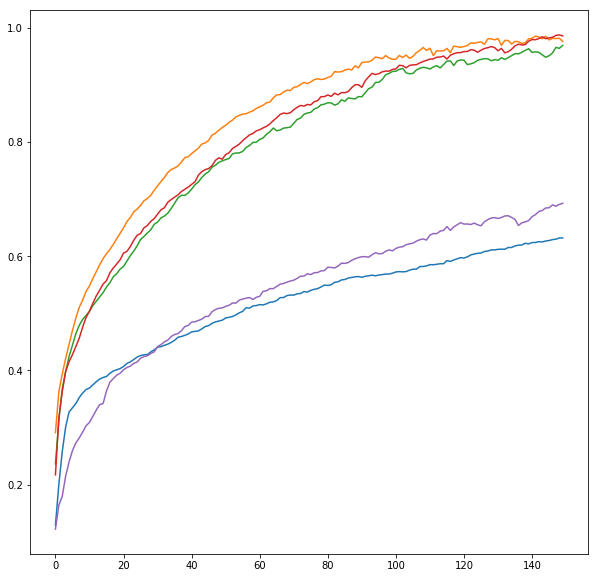

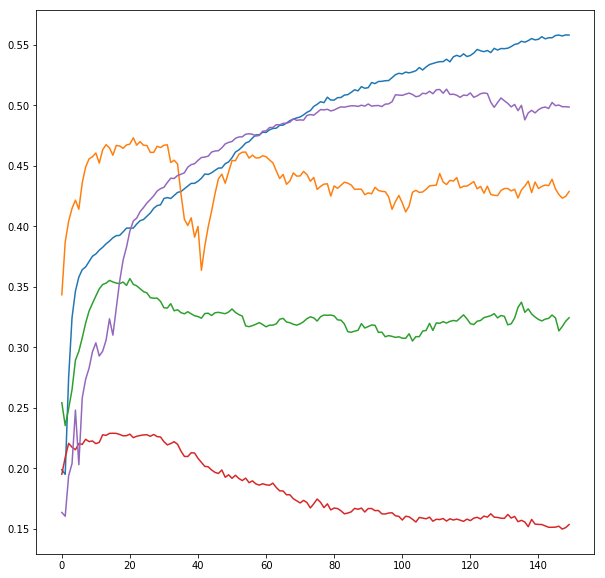

In [10]:
# read and plot all accuracy
normal = np.load('Normal/train.npy')
batch  = np.load("batch Norm/train.npy")
layer  = np.load("Layer Norm/train.npy")
instace= np.load("Instace Norm/train.npy")
boxcox = np.load("Box Cox/train.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

normal = np.load('Normal/test.npy')
batch  = np.load("batch Norm/test.npy")
layer  = np.load("Layer Norm/test.npy")
instace= np.load("Instace Norm/test.npy")
boxcox = np.load("Box Cox/test.npy")

plt.figure(figsize=(10,10))
plt.plot(normal); plt.plot(batch); plt.plot(layer); plt.plot(instace); plt.plot(boxcox); 
plt.show()

# Reference
1. mttk/STL10. (2018). GitHub. Retrieved 19 December 2018, from https://github.com/mttk/STL10
2. regularization?, W. (2016). Why is the penalty term added instead of subtracting it from loss term in regularization?. Cross Validated. Retrieved 26 December 2018, from https://stats.stackexchange.com/questions/236830/why-is-the-penalty-term-added-instead-of-subtracting-it-from-loss-term-in-regula
3. (2018). Bsp.brain.riken.jp. Retrieved 26 December 2018, from http://www.bsp.brain.riken.jp/publications/2003/ICA03KarvCich.pdf
4. Hurley, N., & Rickard, S. (2008). Comparing Measures of Sparsity. arXiv.org. Retrieved 26 December 2018, from https://arxiv.org/abs/0811.4706

<a href="https://stats.stackexchange.com/questions/236830/why-is-the-penalty-term-added-instead-of-subtracting-it-from-loss-term-in-regula"> Good Derivative </a>